In [1]:
%env CUDA_VISIBLE_DEVICES ""

env: CUDA_VISIBLE_DEVICES=""


In [2]:
from mp_20_utils import load_all_data
dataset = "mp_20_biternary"
#dataset = "mp_20"
datasets_pd, torch_datasets, site_to_ids, element_to_ids, spacegroup_to_ids, max_len, max_enumeration, enumeration_stop, enumeration_pad = load_all_data(
    dataset=dataset)

In [3]:
from cascade_transformer.model import CascadeTransformer
from wyckoff_transformer import WyckoffTrainer
from tokenization import PAD_TOKEN, MASK_TOKEN
n_space_groups = len(spacegroup_to_ids)
# Not all 230 space groups are present in the data
# Embedding doesn't support uint8. Sad!
import torch
dtype = torch.int64
device = 'cpu'
cascade_order = ("elements", "symmetry_sites", "symmetry_sites_enumeration")
# (N_i, d_i, pad_i)
assert max_enumeration + 1 == enumeration_stop
assert max_enumeration + 2 == enumeration_pad
enumeration_mask = max_enumeration + 3
assert enumeration_mask < torch.iinfo(dtype).max

cascade = (
    (len(element_to_ids), 64, torch.tensor(element_to_ids[PAD_TOKEN], dtype=dtype, device=device)),
    (len(site_to_ids), 64, torch.tensor(site_to_ids[PAD_TOKEN], dtype=dtype, device=device)),
    (enumeration_mask + 1, None, torch.tensor(enumeration_pad, dtype=dtype, device=device))
)
model = CascadeTransformer(
    n_start=n_space_groups,
    cascade=cascade,
    n_head=1,
    d_hid=170,
    n_layers=3,
    dropout=0.1).to(device)
model.load_state_dict(torch.load('checkpoints/2024-05-24_00-33-24/best_model_params.pt', map_location=device))
model.eval()

CascadeTransformer(
  (embedding): CascadeEmbedding(
    (embeddings): ModuleList(
      (0): Embedding(90, 64, padding_idx=87)
      (1): Embedding(78, 64, padding_idx=27)
      (2): None
    )
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=129, out_features=129, bias=True)
        )
        (linear1): Linear(in_features=129, out_features=170, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=170, out_features=129, bias=True)
        (norm1): LayerNorm((129,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((129,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (start_embedding): Embedding(172, 129)
  (prediction_heads): ModuleList(
    (0): 

In [4]:
from wyckoff_transformer import WyckoffGenerator
mask_dict = {
    "elements": element_to_ids[MASK_TOKEN],
    "symmetry_sites": site_to_ids[MASK_TOKEN],
    "symmetry_sites_enumeration": enumeration_mask
}
generator = WyckoffGenerator(
    model,
    cascade_order,
    mask_dict,
    max_len,
    device="cpu")

In [5]:
generated_tensors = generator.generate_tensors(torch_datasets['test']['spacegroup_number'].type(dtype).to(device))

In [6]:
generated_tensors.shape

torch.Size([7118, 20, 3])

In [7]:
idx_to_element = {idx: element for element, idx in element_to_ids.items()}
idx_to_site = {idx: site for site, idx in site_to_ids.items()}
idx_to_spacegroup = {idx: spacegroup for spacegroup, idx in spacegroup_to_ids.items()}
import pickle
with open("wychoffs_enumerated_by_ss.pkl.gz", "rb") as f:
    _, letter_from_ss_enum, _ = pickle.load(f)
from tokenization import PAD_TOKEN, MASK_TOKEN, STOP_TOKEN
SITE_PAD_ID = site_to_ids[PAD_TOKEN]
ELEMENT_PAD_ID = element_to_ids[PAD_TOKEN]
ELEMENT_STOP_ID = element_to_ids[STOP_TOKEN]

In [8]:
from collections import defaultdict
from pyxtal.symmetry import Group
wp_index = defaultdict(lambda: defaultdict(dict))
for group_number in range(1, 231):
    group = Group(group_number)
    for wp in group.Wyckoff_positions:
        wp.get_site_symmetry()
        wp_index[group_number][wp.site_symm][wp.letter] = (wp.multiplicity, wp.get_dof())

In [9]:
import logging
from copy import deepcopy
logging.basicConfig(level=logging.INFO)
def tensors_to_pyxtal(tensor, space_group, enforced_num_elements = None):
    space_group_real = int(idx_to_spacegroup[int(space_group)])
    pyxtal_args = defaultdict(lambda: [0, []])
    available_sites = deepcopy(wp_index[space_group_real])
    for element_tensor, ss_tensor, enum_tensor in tensor:
        if element_tensor == ELEMENT_STOP_ID:
            break
        if element_tensor == ELEMENT_PAD_ID:
            logging.info("PAD element")
            return None
        element = idx_to_element[element_tensor.item()]
        if ss_tensor == SITE_PAD_ID:
            logging.info("PAD site")
            return None
        ss = idx_to_site[ss_tensor.item()]
        try:
            wp_letter = letter_from_ss_enum[space_group_real][ss][enum_tensor.item()]
        except KeyError:
            logging.info("Invalid WP letter: %i, %s, %i", space_group_real, ss, enum_tensor.item())
            return None
        try:
            our_site = available_sites[ss][wp_letter]
        except KeyError:
            logging.info("Repeated special WP: %i, %s, %s", space_group_real, ss, wp_letter)
            return None
        pyxtal_args[element][0] += our_site[0]
        pyxtal_args[element][1].append(str(our_site[0])+wp_letter)
        if our_site[1] == 0: # The position is special
            del available_sites[ss][wp_letter]
    # TODO: move up
    if enforced_num_elements is not None and len(pyxtal_args.keys()) != enforced_num_elements:
        logging.info("Invalid number of elements")
        return None
    if len(pyxtal_args) == 0:
        logging.info("No structure generated, STOP is the first token")
        return None
    return {
            "spacegroup": space_group_real,
            "sites": [x[1] for x in pyxtal_args.values()],
            "elements": list(map(str, pyxtal_args.keys())),
            "composition": [x[0] for x in pyxtal_args.values()]
        }

In [10]:
letter_from_ss_enum[194]

defaultdict(dict,
            {'1': {0: 'l', 1: 'k', 2: 'i'},
             'm..': {0: 'j'},
             'm2.': {0: 'h'},
             '-1': {0: 'g'},
             '3m.': {0: 'f', 1: 'e'},
             '-622m2': {0: 'd', 1: 'c', 2: 'b'},
             '-32/m.': {0: 'a'}})

In [11]:
from pyxtal.symmetry import Group
group = Group(194)

In [12]:
group

-- Spacegroup --# 194 (P63/mmc)--
24l	site symm: 1
12k	site symm: 1
12j	site symm: m..
12i	site symm: 1
6h	site symm: m2.
6g	site symm: -1
4f	site symm: 3m.
4e	site symm: 3m.
2d	site symm: -622m2
2c	site symm: -622m2
2b	site symm: -622m2
2a	site symm: -32/m.

In [13]:
valid_generated = []
for tensor, space_group in zip(generated_tensors, torch_datasets['test']['spacegroup_number']):
    generated = tensors_to_pyxtal(tensor, space_group)
    if generated is not None:
        valid_generated.append(generated)
print(len(valid_generated), len(generated_tensors), len(valid_generated)/len(generated_tensors))

INFO:root:Repeated special WP: 65, mmm, a
INFO:root:Invalid WP letter: 58, m.2m, 0
INFO:root:Repeated special WP: 71, mmm, a
INFO:root:Invalid WP letter: 139, 2/m2/m., 0
INFO:root:Invalid WP letter: 191, m.m2, 0
INFO:root:Repeated special WP: 225, m-3m, b
INFO:root:Invalid WP letter: 86, 422, 0
INFO:root:Repeated special WP: 194, -622m2, c
INFO:root:Repeated special WP: 139, 4/mmm, a
INFO:root:Invalid WP letter: 72, 22., 0
INFO:root:Invalid WP letter: 62, m.., 0
INFO:root:Invalid WP letter: 194, 2m., 0
INFO:root:Invalid WP letter: 82, 3., 0
INFO:root:Repeated special WP: 225, m-3m, b
INFO:root:Invalid WP letter: 148, .m., 0
INFO:root:Repeated special WP: 225, m-3m, b
INFO:root:Repeated special WP: 123, 4/mmm, d
INFO:root:Repeated special WP: 123, 4/mmm, c
INFO:root:Repeated special WP: 225, m-3m, b
INFO:root:Invalid WP letter: 191, m-3., 0
INFO:root:Repeated special WP: 225, m-3m, b
INFO:root:Repeated special WP: 123, 4/mmm, c
INFO:root:Repeated special WP: 187, -622m2, e
INFO:root:Inv

4359 7118 0.612391121101433


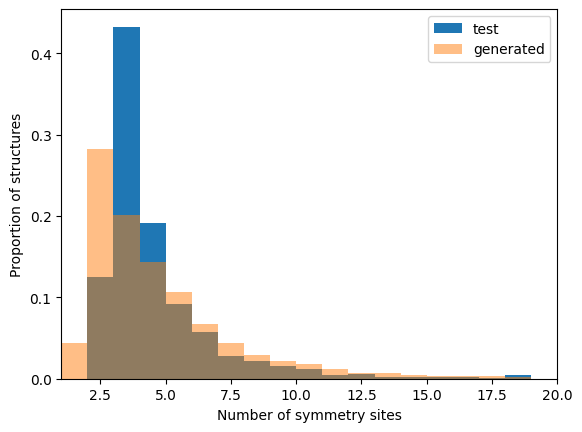

In [14]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = np.arange(1, max_len)
ax.hist(datasets_pd['test'].symmetry_sites.map(len), label="test", density=True, bins=x)
#ax.hist(datasets_pd['train'].symmetry_sites.map(len), label="train", density=True, alpha=0.5, bins=x)
ax.hist(list(map(lambda s: sum(map(len, s['sites'])), valid_generated)), label="generated", density=True, alpha=0.5, bins=x)
ax.set_xlabel("Number of symmetry sites")
ax.set_ylabel("Proportion of structures")
ax.legend()
ax.set_xlim(1, max_len);

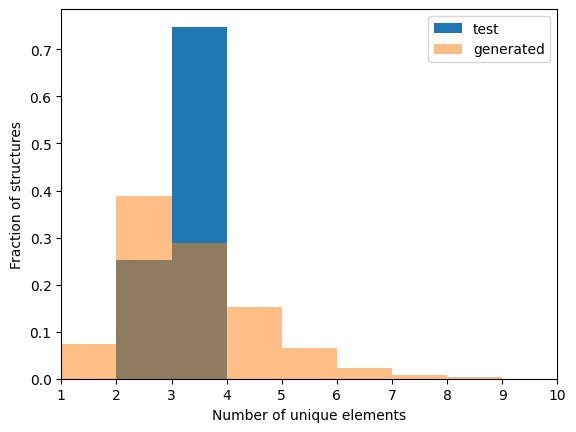

In [15]:
def count_elements(record):
    return len(set(record["elements"]))
def count_elements_pd(record):
    return len(set(record.structure.elements))
fig, ax = plt.subplots()
bins = np.arange(1, 10)
ax.hist(datasets_pd['test'].apply(count_elements_pd, axis=1), label="test", density=True, bins=bins)
#ax.hist(datasets_pd['train'].apply(count_elements_pd, axis=1), label="train", density=True, alpha=0.5, bins=bins)
ax.hist(list(map(count_elements, valid_generated)), label="generated", density=True, alpha=0.5, bins=bins)
ax.set_xlabel("Number of unique elements")
ax.set_ylabel("Fraction of structures")
ax.legend()
ax.set_xlim((1,10));

In [16]:
import pyxtal
example = valid_generated[2]
generator = pyxtal.pyxtal()
generator.from_random(3, group=example["spacegroup"], species=example["elements"],
                      numIons=example["composition"], sites=example["sites"])

In [17]:
example

{'spacegroup': 164,
 'sites': [['2d'], ['2d'], ['2d']],
 'elements': ['Tm', 'Ge', 'Mn'],
 'composition': [2, 2, 2]}

In [18]:
ase_struct = generator.to_ase()
import ase.visualize
ase.visualize.view(ase_struct, viewer="ngl")

In [19]:
import json
with open(f"generated_{dataset}.json", "w") as f:
    json.dump(valid_generated, f)